In [35]:
import glob
import logging
import os
import numpy as np
import re
import soundfile
from keras.models import model_from_json
from numpy.lib.stride_tricks import as_strided
import scipy.fftpack as fftpack

In [2]:
import stft
import scipy.io.wavfile as wav
fs, audio = wav.read('./wav/652-129742-0000.wav')
specgram = stft.spectrogram(audio)





(32898.643797168043+508.97119953387266j)

In [406]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram
    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).
    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x
    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    #x[1:-1, :] *= (2.0 / scale)
    #x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [401]:
def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        print('sample_rate', sample_rate)
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        print('hop_length', hop_length);
        print('fft_length', fft_length);
        print('samples', len(audio))
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        print(len(pxx))
        print(len(pxx[0]))
#        print(freq)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
        print('ind', ind)
    return np.transpose(np.log(pxx[:ind, :] + eps)) 

In [407]:
s = spectrogram_from_file('./wav/652-129742-0000.wav')


sample_rate 16000
hop_length 160
fft_length 320
samples 96400
161
601
ind 161


In [408]:
s.shape

(601, 161)

In [409]:
s[0]

array([ -4.11507081,  -5.06508683,  -7.86429047,  -8.8264424 ,
       -11.91750089,  -9.44209069,  -8.8859135 ,  -9.34770234,
       -11.89610167,  -8.95836554,  -9.61700916, -11.25020723,
       -13.57938413, -12.18361392, -11.07329364, -12.32975651,
       -10.8406062 , -10.19992172, -11.72246432, -11.72096237,
       -11.47842496, -13.35207748, -11.21665558, -10.98897632,
       -12.11220247, -11.24314108, -11.32890728, -11.5416631 ,
       -10.46718139, -12.21480475, -13.40800326, -12.03339044,
       -11.15490666, -11.14735044, -14.40784628, -13.54067408,
       -11.73460083, -11.25619379, -13.67675884, -13.80522233,
       -13.60312067, -12.95668737, -11.84342585, -11.31587017,
       -12.28040974, -14.10580735, -12.48596529, -11.86458275,
       -12.29768691, -13.53456092, -12.90832757, -11.96475199,
       -14.06442456, -13.92731347, -15.24812933, -12.50633567,
       -11.31932718, -11.54653668, -12.79856055, -12.76945192,
       -11.55307428, -14.93874498, -13.67660123, -12.44

In [389]:
spec_ba, freq = spectrogram(
            audio, fft_length=320, sample_rate=16000,
            hop_length=160)
ind = np.where(freqs <= sample_rate/2)[0][-1] + 1
spec_ba = np.transpose(np.log(spec_ba[:ind, :] + eps))

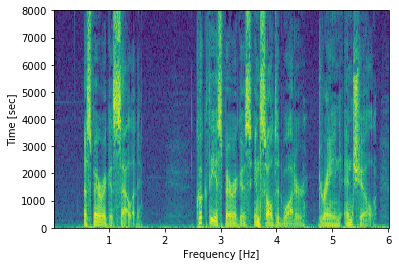

In [391]:
plt.pcolormesh(bins,freq,  np.transpose(spec_ba))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time [sec]')
plt.show()

In [393]:
spec_ba[1]

array([-17.88782299, -16.91218378, -18.74054425, -24.80161773,
       -23.68513062, -25.41391889, -24.70358552, -25.51772886,
       -24.21734335, -23.34060333, -24.12422494, -25.59305637,
       -24.4082135 , -23.69348582, -24.53975236, -24.21523643,
       -25.03724723, -25.74556709, -24.68586905, -25.81608841,
       -29.37776815, -26.99554961, -25.94085368, -26.73384706,
       -25.68174661, -24.89997501, -25.43226421, -26.36329949,
       -27.44446094, -25.562946  , -25.90959429, -26.02005483,
       -25.96980418, -28.44306741, -28.25960044, -28.14261275,
       -27.1285437 , -25.18777306, -25.75066277, -29.06000712,
       -26.97106965, -27.47302733, -25.71979601, -25.81961703,
       -28.19666815, -25.73318587, -28.37839159, -26.94645088,
       -26.96394728, -25.81283444, -25.56675906, -26.39420304,
       -26.10642057, -26.6088806 , -26.15335799, -25.95296968,
       -26.47624535, -25.62592611, -25.99190343, -26.91140424,
       -27.01937819, -27.64114355, -26.74844431, -25.69

In [291]:
spec_ba[1]


array([ -3.42311773,  -3.14062533,  -4.96898696, -11.03064971,
        -9.91376531, -11.64345005, -10.93256234, -11.74737931,
       -10.44611393,  -9.56918166, -10.35296624, -11.82280149,
       -10.63705334,  -9.92212213, -10.76864823, -10.44400631,
       -11.26643621, -11.97552717, -10.91483645, -12.04615955,
       -15.66527932, -13.22930187, -12.1711416 , -12.96637392,
       -11.91161272, -11.12906806, -11.66181556, -12.59455951,
       -13.68123497, -11.79265242, -12.13982533, -12.2504951 ,
       -12.20014639, -14.69429141, -14.5069692 , -14.38787417,
       -13.3630537 , -11.41708355, -11.98063062, -15.33108939,
       -13.20469314, -13.71004386, -11.94971742, -12.04969394,
       -14.44287216, -11.96312725, -14.6281734 , -13.17994803,
       -13.1975339 , -12.04290029, -11.79647031, -12.62555165,
       -12.33704136, -12.84092666, -12.38408362, -12.18328013,
       -12.70784294, -11.85571482, -12.22228816, -13.14472684,
       -13.25325887, -13.87973798, -12.98103137, -11.92

In [270]:
spec_ba.shape

(601, 161)

In [175]:
from matplotlib import *
from pylab import *

In [333]:
Fs=16000
eps=1e-14
fft_length=320
hop_length=160
NWindow = 320
window = np.hanning(NWindow)
sound_file = soundfile.SoundFile('./wav/652-129742-0000.wav')
audio = sound_file.read(dtype='float32')
sample_rate = sound_file.samplerate
max_freq=sample_rate / 2
Pxx, freqs, bins = mlab.specgram(audio, NFFT=fft_length, Fs=Fs, noverlap=hop_length,window=window)
ind = np.where(freqs <= max_freq)[0][-1] + 1 
z=np.transpose(np.log(Pxx[:ind, :] + eps))

In [423]:
Pxx[:, :].shape

(161, 601)

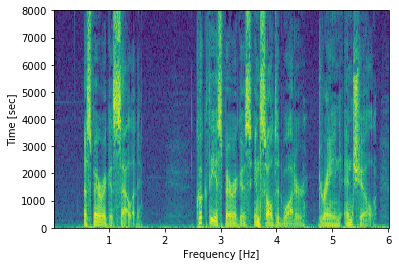

In [348]:
plt.pcolormesh(bins,freqs, np.transpose(z))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time [sec]')
plt.show()

In [354]:
z[1][2]

-18.74054425481059

In [355]:
import scipy.signal
from scipy.signal import spectrogram


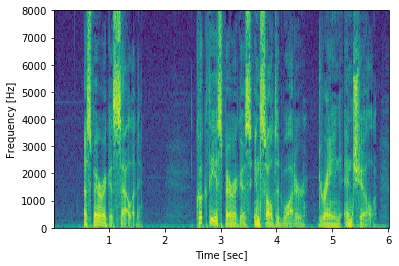

In [380]:
t,f, sxx = scipy.signal.spectrogram(audio, fs=sample_rate, nperseg=fft_length, window=window, noverlap=160)
sxx = np.transpose(np.log(sxx[:, :] + eps))

plt.pcolormesh( f,t, np.transpose(sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

array([    0.,    50.,   100.,   150.,   200.,   250.,   300.,   350.,
         400.,   450.,   500.,   550.,   600.,   650.,   700.,   750.,
         800.,   850.,   900.,   950.,  1000.,  1050.,  1100.,  1150.,
        1200.,  1250.,  1300.,  1350.,  1400.,  1450.,  1500.,  1550.,
        1600.,  1650.,  1700.,  1750.,  1800.,  1850.,  1900.,  1950.,
        2000.,  2050.,  2100.,  2150.,  2200.,  2250.,  2300.,  2350.,
        2400.,  2450.,  2500.,  2550.,  2600.,  2650.,  2700.,  2750.,
        2800.,  2850.,  2900.,  2950.,  3000.,  3050.,  3100.,  3150.,
        3200.,  3250.,  3300.,  3350.,  3400.,  3450.,  3500.,  3550.,
        3600.,  3650.,  3700.,  3750.,  3800.,  3850.,  3900.,  3950.,
        4000.,  4050.,  4100.,  4150.,  4200.,  4250.,  4300.,  4350.,
        4400.,  4450.,  4500.,  4550.,  4600.,  4650.,  4700.,  4750.,
        4800.,  4850.,  4900.,  4950.,  5000.,  5050.,  5100.,  5150.,
        5200.,  5250.,  5300.,  5350.,  5400.,  5450.,  5500.,  5550.,
      

In [364]:
sxx.shape

(161, 601)

In [370]:
z[0]

array([-18.57977549, -18.83664399, -21.63582423, -22.59793588,
       -25.68762636, -23.21352871, -22.65740299, -23.11915123,
       -25.66625747, -22.72984983, -23.38842412, -25.02103028,
       -27.34341398, -25.95330285, -24.84423593, -26.09915153,
       -24.61167642, -23.97122298, -25.4928436 , -25.49134342,
       -25.24905951, -27.11763353, -24.98750289, -24.75996844,
       -25.88202016, -25.0139693 , -25.09967012, -25.31223736,
       -24.23840379, -25.9844345 , -27.17321513, -25.80333996,
       -24.92579655, -24.91824536, -28.16224845, -27.30498877,
       -25.50496571, -25.02701242, -27.44002188, -27.56735354,
       -27.36697036, -26.72419981, -25.61365358, -25.08664331,
       -26.04990883, -27.86465378, -26.25499496, -25.63478205,
       -26.06715014, -27.29891959, -26.67603066, -25.73480817,
       -27.82378318, -27.68822695, -28.98037597, -26.27531337,
       -25.09009761, -25.31710613, -26.56666377, -26.5376541 ,
       -25.32363725, -28.68130263, -27.43986556, -26.21

In [371]:
sxx[0]

array([-21.08048248, -20.03457642, -21.63537407, -22.60191727,
       -25.68177605, -23.21277428, -22.6581192 , -23.11855316,
       -25.66419411, -22.73032188, -23.38778877, -25.02190781,
       -27.34325409, -25.95480919, -24.84349442, -26.09952736,
       -24.61171341, -23.97126389, -25.492733  , -25.49149323,
       -25.24881172, -27.11731148, -24.98763847, -24.76004219,
       -25.88195038, -25.01386452, -25.09970474, -25.31248665,
       -24.23827553, -25.9847374 , -27.1737175 , -25.80309868,
       -24.92585754, -24.91825104, -28.16178894, -27.30501366,
       -25.5049572 , -25.02700615, -27.44014549, -27.56728172,
       -27.36686516, -26.72423744, -25.61372948, -25.0865593 ,
       -26.05003357, -27.86496162, -26.25491142, -25.63478279,
       -26.06716728, -27.29888344, -26.67615509, -25.73472786,
       -27.82390404, -27.68842697, -28.98071289, -26.27528381,
       -25.09007454, -25.31715012, -26.56657028, -26.53764343,
       -25.32365608, -28.68113327, -27.43986702, -26.21

In [374]:
spec_ba[
    1]

array([ -3.42311773,  -3.14062533,  -4.96898696, -11.03064971,
        -9.91376531, -11.64345005, -10.93256234, -11.74737931,
       -10.44611393,  -9.56918166, -10.35296624, -11.82280149,
       -10.63705334,  -9.92212213, -10.76864823, -10.44400631,
       -11.26643621, -11.97552717, -10.91483645, -12.04615955,
       -15.66527932, -13.22930187, -12.1711416 , -12.96637392,
       -11.91161272, -11.12906806, -11.66181556, -12.59455951,
       -13.68123497, -11.79265242, -12.13982533, -12.2504951 ,
       -12.20014639, -14.69429141, -14.5069692 , -14.38787417,
       -13.3630537 , -11.41708355, -11.98063062, -15.33108939,
       -13.20469314, -13.71004386, -11.94971742, -12.04969394,
       -14.44287216, -11.96312725, -14.6281734 , -13.17994803,
       -13.1975339 , -12.04290029, -11.79647031, -12.62555165,
       -12.33704136, -12.84092666, -12.38408362, -12.18328013,
       -12.70784294, -11.85571482, -12.22228816, -13.14472684,
       -13.25325887, -13.87973798, -12.98103137, -11.92

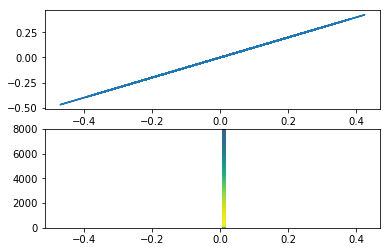

In [332]:
ax1 = plt.subplot(211)
dt = 1/sample_rate
plt.plot(audio, audio)
plt.subplot(212, sharex=ax1)
Pxx, freqs, bins, im = plt.specgram(x, NFFT=fft_length, Fs=Fs, noverlap=160)
plt.show()


In [313]:
z.shape

(601, 161)

In [272]:
z.shape

(601, 161)

array([-18.57977549, -18.83664399, -21.63582423, -22.59793588,
       -25.68762636, -23.21352871, -22.65740299, -23.11915123,
       -25.66625747, -22.72984983, -23.38842412, -25.02103028,
       -27.34341398, -25.95330285, -24.84423593, -26.09915153,
       -24.61167642, -23.97122298, -25.4928436 , -25.49134342,
       -25.24905951, -27.11763353, -24.98750289, -24.75996844,
       -25.88202016, -25.0139693 , -25.09967012, -25.31223736,
       -24.23840379, -25.9844345 , -27.17321513, -25.80333996,
       -24.92579655, -24.91824536, -28.16224845, -27.30498877,
       -25.50496571, -25.02701242, -27.44002188, -27.56735354,
       -27.36697036, -26.72419981, -25.61365358, -25.08664331,
       -26.04990883, -27.86465378, -26.25499496, -25.63478205,
       -26.06715014, -27.29891959, -26.67603066, -25.73480817,
       -27.82378318, -27.68822695, -28.98037597, -26.27531337,
       -25.09009761, -25.31710613, -26.56666377, -26.5376541 ,
       -25.32363725, -28.68130263, -27.43986556, -26.21